In [874]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy.linalg import inv, det
from scipy.io import loadmat
from skimage.io import imread, imshow
import scipy.misc
from scipy.optimize import fmin_cg, fmin_ncg

In [89]:
data = loadmat('ex8data1.mat', mat_dtype=True)
X = data['X']
Xval = data['Xval']
yval = data['yval']

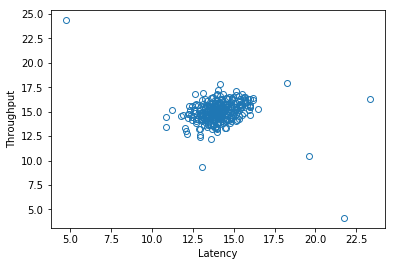

In [90]:
plt.plot(X[:,0], X[:,1], linestyle='', marker='o', markerfacecolor='none')
plt.xlabel('Latency')
plt.ylabel('Throughput')
plt.show()

In [678]:
def estimateGaussian(X):
    m=X.shape[0]
    mu_vec = X.mean(axis=0)
    sigma_vec = X.std(axis=0)
    cov_mx = (X-mu_vec).T.dot(X-mu_vec)/(m-1)
    return mu_vec, sigma_vec**2, cov_mx

In [665]:
muX, sigmaX, covX = estimateGaussian(X)

In [699]:
covX11 = np.diag(sigmaX)

In [700]:
a = np.array([1,2])
b = np.array([[1,2],[3,4]])
a.T.dot(b)

array([ 7, 10])

In [492]:
def multivariateGaussian(X, mu, cov):
    n = mu.size
    X_loc = X.copy()#reshape(X.size,1)
    mu_loc = mu.copy()#reshape(mu.size,1)
    print(mu_loc.shape)
    print(X_loc.shape)
    normalizedX = X_loc-mu_loc
    mult1 = (2*np.pi)**(-n/2) * det(cov)**-.5
    mult2 = np.e**-(normalizedX.dot(inv(cov)).dot(normalizedX.T)/2)
    print(mult2)
    return mult1*mult2 

def gridMultivariateGaussian(X, mu, cov):
    n = mu.size
    normalizedX = X-mu
    mult1 = (2*np.pi)**(-n/2) * det(cov)**-.5
    power = np.einsum('...i,ij->...j', normalizedX, inv(cov))
#     print(power.shape)
    power = np.einsum('...j,...j', power, normalizedX)
#     power = np.einsum('...i,ij,...j->...', normalizedX, inv(cov), normalizedX)
#     print(power.shape)
#     print(power)
    mult2 = np.e**(-power/2)
#     print(mult2)
    return mult1*mult2 

In [713]:
x1 = np.linspace(5,25,80)
x2 = np.linspace(5,25,100)
# a = np.array([x1,x2])
x1,x2 = np.meshgrid(x1,x2)
# x1 = x1.reshape(1,x1.shape[0], x1.shape[1])
# x2 = x2.reshape(1,x2.shape[0], x2.shape[1])

a = np.empty(x1.shape+(2,))
a[:,:,0] = x1
a[:,:,1] = x2

cont = gridMultivariateGaussian(a, muX, covX)

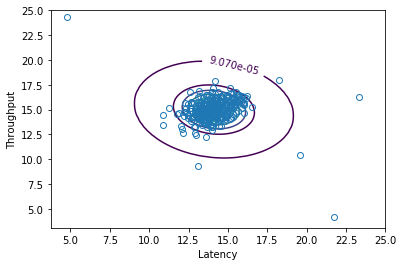

In [714]:
plt.plot(X[:,0], X[:,1], linestyle='', marker='o', markerfacecolor='none')
plt.xlabel('Latency')
plt.ylabel('Throughput')
cplot = plt.contour(x1,x2,cont,levels=[9.07e-5])
plt.contour(x1,x2,cont)
plt.clabel(cplot, fmt='%1.3e')
# plt.contour(x1,x2,cont,levels=np.geomspace(1e-20,1e-4,10))
cmap=cm.viridis
plt.show()

Probability threshold selection

In [711]:
pval = gridMultivariateGaussian(Xval, muX, covX)

In [707]:
def selectThreshold(pval, yval):
    bestEpsilon=0
    bestF1=0
    minP = pval.min()
    maxP = pval.max()
    stepsize = (maxP - minP)/1000
    for epsilon in np.arange(minP, maxP, stepsize):
        pred = pval < epsilon
        tp = ((pred==yval) & (yval==1)).sum()
        fp = ((pred!=yval) & (yval==0)).sum()
        fn = ((pred!=yval) & (yval==1)).sum()
        if (tp+fp==0) or (tp+fn==0):
            F1 = 0
        else:
            prec = tp/(tp+fp)
            rec = tp/(tp+fn)
            F1 = 2*prec*rec/(prec+rec)
        if F1>bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    return bestEpsilon, bestF1

In [712]:
epsilon, F1 = selectThreshold(pval, yval.flatten())
print('epsilon = {:1.3e}, F1-score = {:1.3f}'.format(epsilon, F1))

epsilon = 9.036e-05, F1-score = 0.875


In [615]:
data2 = loadmat('ex8data2.mat', mat_dtype=True)

data2.keys()
X2 = data2['X']
Xval2 = data2['Xval']
yval2 = data2['yval']

In [679]:
muX2, sigmaX2, covX2 = estimateGaussian(X2)

In [680]:
covX21=np.diag(sigmaX2)

In [689]:
pval2 = gridMultivariateGaussian(Xval2, muX2, covX21)
p = gridMultivariateGaussian(X2, muX2, covX21)

In [686]:
epsilon2, F12 = selectThreshold(pval2, yval2.flatten())
print('epsilon = {:1.3e}, F1-score = {:1.3f}'.format(epsilon2, F12))

1.37722883123e-18
epsilon = 1.377e-18, F1-score = 0.615


In [690]:
(p<epsilon2).sum()

117


# Collaborative filtering

In [721]:
movies = loadmat('ex8_movies.mat', mat_dtype=True)
Y = movies['Y']
R = movies['R']

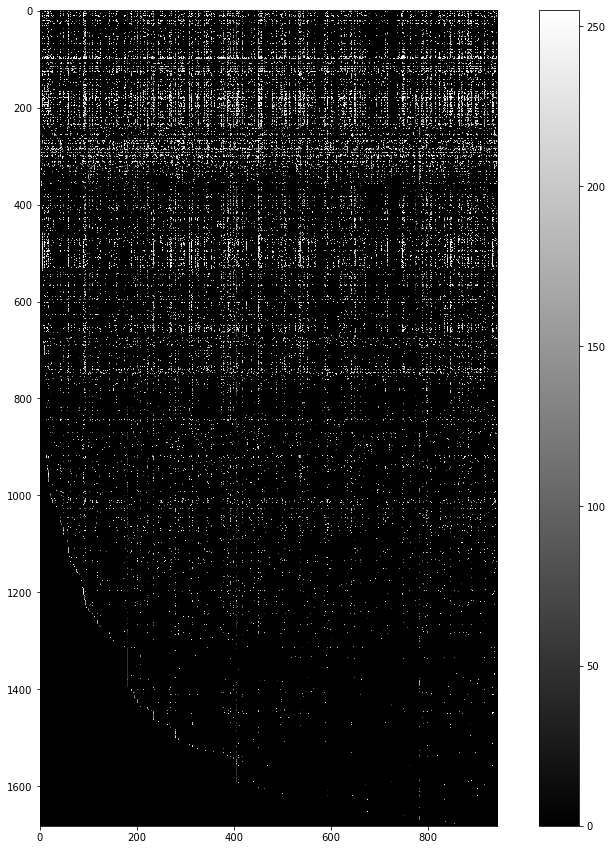

In [748]:
plt.figure(figsize=[15,15])
plt.imshow(scipy.misc.toimage(Y), cmap='gray')
plt.colorbar()
plt.show()

In [961]:
movieP = loadmat('ex8_movieParams.mat', mat_dtype=True)
# Y = movies['Y']
# R = movies['R']

X = movieP['X']
Theta = movieP['Theta']
cofi_params = np.concatenate((X.flatten(), Theta.flatten()))
num_movies = movieP['num_movies'].flatten()[0].astype(int)
num_features = movieP['num_features'].flatten()[0].astype(int)
num_users = movieP['num_users'].flatten()[0].astype(int)

In [953]:
num_users = 4
num_movies = 5
num_features = 3

In [919]:
def cofiCostFunc(cofi_params, Y, R, num_users, num_features, num_movies, lmbd):    
    X = cofi_params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = cofi_params[num_movies*num_features:].reshape(num_users, num_features)
    preds = (X.dot(Theta.T)-Y)*(R==1)
    reg_term = lmbd * np.einsum('i,i->', cofi_params, cofi_params)
    cost = np.einsum('ij,ij->',preds,preds)
    return (cost+reg_term)/2

def cofiGradFunc(cofi_params, Y, R, num_users, num_features, num_movies, lmbd):
    X = cofi_params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = cofi_params[num_movies*num_features:].reshape(num_users, num_features)
    preds = (X.dot(Theta.T)-Y)*(R==1)
    gradX = np.einsum('ij,jk', preds,Theta) + lmbd*X 
    gradT = np.einsum('ji,jk', preds, X) + lmbd*Theta
    return np.append(gradX.flatten(), gradT.flatten(), axis=0)

def gradChecking(cofi_params, costFunc, epsilon, Y, R, num_users, num_features, num_movies, lmbd):
    grad_approx = np.empty(cofi_params.size)
    for i in range(cofi_params.size):
        theta_plus = cofi_params.copy()
        theta_plus[i] += epsilon
        theta_minus = cofi_params.copy()
        theta_minus[i] -= epsilon
        grad_approx[i] = (costFunc(theta_plus,Y,R,num_users, num_features, num_movies,0) - costFunc(theta_minus,Y,R,num_users, num_features, num_movies,0))/2/epsilon
    return grad_approx

In [962]:
X_init = np.random.random(X.shape)*5-2.5
T_init = np.random.random(Theta.shape)*5-2.5
cofi_params = np.concatenate((X.flatten(), Theta.flatten()))
cofi_params_rdcd = np.concatenate((X[:num_movies, :num_features].flatten(), Theta[:num_users, :num_features].flatten()))
cofi_params_init = np.concatenate((X_init.flatten(), T_init.flatten()))
cofi_params_rdcd_init = np.concatenate((X_init[:num_movies, :num_features].flatten(), T_init[:num_users, :num_features].flatten()))

In [964]:
T_init[:5,:5]

array([[-2.18853116,  1.87027771, -2.38269582, -0.62431853, -0.58351119],
       [ 0.26044865,  0.48166578, -1.41462647, -1.60642627,  0.2429556 ],
       [ 1.08753896,  2.35119264,  0.26249046, -1.53275954, -2.29056969],
       [ 1.06993996,  0.07219126,  2.41869713, -1.42815036, -0.81455959],
       [ 2.43542334,  0.64897554,  1.46592744,  1.34014535, -0.23729141]])

In [958]:
cofiCostFunc(cofi_params_rdcd,Y[:num_movies, :num_users],R[:num_movies, :num_users],num_users, num_features, num_movies,1.5)

31.344056244274221

In [921]:
realGrad = cofiGradFunc(cofi_params_rdcd_init,Y[:num_movies, :num_users],R[:num_movies, :num_users],num_users, num_features, num_movies,0)

In [928]:
gradApprox = gradChecking(cofi_params_rdcd_init, cofiCostFunc, 1e-10, Y[:num_movies, :num_users],R[:num_movies, :num_users],num_users, num_features, num_movies,0)

In [929]:
np.concatenate((realGrad[:,np.newaxis], gradApprox[:,np.newaxis]), axis=1)

array([[-2.35438164, -2.35438335],
       [-5.7166899 , -5.71670711],
       [-4.25874017, -4.25874447],
       [-0.25689894, -0.25689673],
       [-2.17528587, -2.17529106],
       [-1.57885668, -1.57886149],
       [-0.29374335, -0.29375613],
       [-2.48726509, -2.48727261],
       [-1.80529611, -1.80529369],
       [-0.24503603, -0.24503066],
       [-2.07483702, -2.07485584],
       [-1.50594933, -1.5059598 ],
       [-0.27554435, -0.27554847],
       [-2.33316549, -2.33317365],
       [-1.6934482 , -1.6934365 ],
       [-6.97353379, -6.97355063],
       [-7.49047572, -7.49048823],
       [-6.60540868, -6.60541843],
       [-2.11774747, -2.1177371 ],
       [-1.95843024, -1.95843342],
       [-1.13059237, -1.13059784],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

In [951]:
Y[:3,:3]

array([[ 5.,  4.,  0.],
       [ 3.,  0.,  0.],
       [ 4.,  0.,  0.]])

In [968]:
result = fmin_cg(cofiCostFunc, cofi_params_init, fprime=cofiGradFunc, args=(Y,R,num_users, num_features, num_movies,0), maxiter=100)

         Current function value: 27995.924880
         Iterations: 100
         Function evaluations: 153
         Gradient evaluations: 153


In [971]:
X_res = result[:num_movies*num_features].reshape(num_movies, num_features)
Theta_res = result[num_movies*num_features:].reshape(num_users, num_features)

In [969]:
cofiCostFunc(result,Y,R,num_users, num_features, num_movies,0)

27995.924879611561

In [970]:
cofiCostFunc(cofi_params,Y,R,num_users, num_features, num_movies,0)

27918.64012454421

In [982]:
X_res[150:250].dot(Theta_res.T).mean()

3.4782804449127269